In [1]:
%pylab inline
import numpy as np, matplotlib.pyplot as plt
import slimplectic


Populating the interactive namespace from numpy and matplotlib


In [2]:
# One solar mass in seconds
G = 6.67428e-11  #(in m^3/kg/s^2)
c = 2.99792458e8  # (in m/s)
Msun_in_kg = 1.98892e30
Msun_in_sec = G/c**3 * Msun_in_kg
sec_to_km = c/1000.

# Component masses
m1 = 1.4*Msun_in_sec
m2 = 1.4*Msun_in_sec

# Total mass
m = m1+m2

# Symmetric mass ratio
nu = m1*m2/m**2

# Reduced mass
mu = nu*m

Use Cartesian coordinates to describe the orbital separation for now. Instantiate the VariationalIntegrator class.

In [3]:
pn = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['vx', 'vy'])
rk4 = slimplectic.RungeKutta4()

In [156]:
pn6 = slimplectic.GalerkinGaussLobatto('t', ['x', 'y'], ['vx', 'vy'])

In [4]:
# Conservative Lagrangian
L = 0.5*mu*np.dot(pn.v, pn.v) + mu*m/np.dot(pn.q, pn.q)**0.5

# K for arbitrary bound orbits
K = 64./5.*nu**2*m**4*np.dot(pn.vp, pn.qm)/np.dot(pn.qp, pn.qp)**2 \
    - 96./5.*nu**2*m**3*np.dot(pn.vp, pn.vp)*np.dot(pn.vp, pn.qm)/np.dot(pn.qp, pn.qp)**1.5 \
    + 48.*nu**2*m**3*np.dot(pn.vp, pn.qp)**2*np.dot(pn.vp, pn.qm)/np.dot(pn.qp, pn.qp)**2.5 \
    + 64./15.*nu**2*m**4*np.dot(pn.vp, pn.qp)*np.dot(pn.qp, pn.qm)/np.dot(pn.qp, pn.qp)**3 \
    + 288./5.*nu**2*m**3*np.dot(pn.vp, pn.vp)*np.dot(pn.vp, pn.qp)*np.dot(pn.qp, pn.qm)/np.dot(pn.qp, pn.qp)**2.5 \
    - 80.*nu**2*m**3*np.dot(pn.vp, pn.qp)**3*np.dot(pn.qp, pn.qm)/np.dot(pn.qp, pn.qp)**3.5

In [55]:
#Derivative function for Runge-Kutta integrators
def dydt(time, y):
    deriv = numpy.zeros(4)
    #print deriv
    [q_x, q_y, v_x, v_y] = y
    r2 = (q_x*q_x + q_y*q_y)
    v2 = (v_x*v_x + v_y*v_y)
    vdotq = v_x*q_x + v_y*q_y
    deriv[0] = v_x
    deriv[1] = v_y
    deriv[2] = -m*mu*q_x/r2**1.5 
    deriv[2] += 64./5.*nu**2*m**4*v_x/r2**2 \
        - 96./5.*nu**2*m**3*v2*v_x/r2**1.5 \
        + 48.*nu**2*m**3*vdotq**2*v_x/r2**2.5 \
        + 64./15.*nu**2*m**4*vdotq*q_x/r2**3 \
        + 288./5.*nu**2*m**3*v2*vdotq*q_x/r2**2.5 \
        - 80.*nu**2*m**3*vdotq**3*q_x/r2**3.5
    deriv[2] /= mu
    

    deriv[3] = -mu*m*q_y/r2**1.5 
    deriv[3] += 64./5.*nu**2*m**4*v_y/r2**2 \
        - 96./5.*nu**2*m**3*v2*v_y/r2**1.5 \
        + 48.*nu**2*m**3*vdotq**2*v_y/r2**2.5 \
        + 64./15.*nu**2*m**4*vdotq*q_y/r2**3 \
        + 288./5.*nu**2*m**3*v2*vdotq*q_y/r2**2.5 \
        - 80.*nu**2*m**3*vdotq**3*q_y/r2**3.5
    deriv[3] /= mu
    
    return deriv

In [15]:
# Discretize total Lagrangian using a 4th order (r=1) implicit scheme
pn.discretize(L, K, 1, method='implicit')

In [157]:
pn6.discretize(L, K, 2, method='implicit')

In [64]:
# Initial data for quasi-circular inspiral
# (Initial velocity found by calculating the leading correction 
#  to pure circular motion due to radiation reaction.)
q0 = np.array([100., 0.])*m
v0 = np.asarray([-64./5.*nu*(m/q0[0])**3, np.sqrt(m/q0[0])])
pi0 = mu*v0

# Estimate time to "coalescence"
r0 = np.sqrt(q0[0]**2+q0[1]**2)
tcoal = 5./256./nu*(r0/m)**4 * m

# Time samples
dt = 1000*m
t = np.arange(0, tcoal, dt)

In [17]:
# Numerically integrate the equations of motion
q, pi = pn.integrate(q0, pi0, t)

/Users/dtsang/work/code/python/default/lib/python2.7/site-packages/scipy/optimize/minpack.py:227: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [82]:
qx_rk41000, qy_rk41000, vx_rk41000, vy_rk41000 =  rk4.integrate(np.array([q0[0], q0[1], v0[0], v0[1]]), t, dydt)

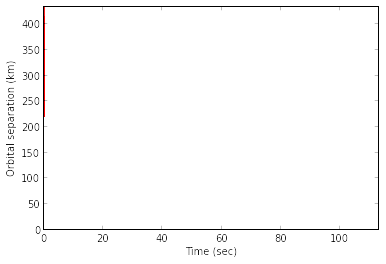

In [66]:
# Numerical orbital separation
r = np.sqrt(q[0]**2+q[1]**2)
r_rk4 = np.sqrt(qx_rk4**2 + qy_rk4**2)
# Analytical orbital separation in the adiabatic approximation
r0 = (q0[0]**2+q0[1]**2)**0.5
def r_adiab(t):
    return np.abs(r0**4-256./5.*m**3*nu*t)**0.25

# Plot the orbital separations
#plt.plot(t, r*sec_to_km, 'b-', t, r_adiab(t)*sec_to_km, 'k--');
plt.plot(t, r_rk4*sec_to_km, 'r-');

plt.xlim(0, 1.05*tcoal);
plt.ylim(0, 1.05*r0*sec_to_km);
plt.xlabel('Time (sec)')
plt.ylabel('Orbital separation (km)')
plt.show()

The absolute errors in the numerical solutions from using $K$ for arbitrary bound orbits compared to the adiabatic approximation are

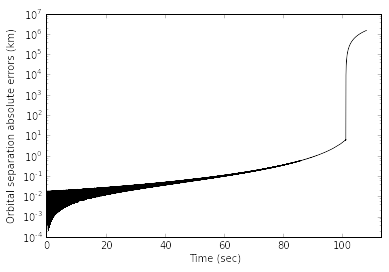

In [10]:
# Plot errors in orbital separation
plt.semilogy(t, np.abs(r_adiab(t)-r)*sec_to_km, 'k-'); 
plt.xlim(0, 1.05*tcoal);
plt.xlabel('Time (sec)')
plt.ylabel('Orbital separation absolute errors (km)')
plt.show()

The numerical solution becomes unstable. The reason is because eventually the period of the orbit becomes comparable to or smaller than the time-step, $dt$. Actually, from some studies in Mathematica you can show that adaptive methods are better-suited to this problem. For fixed time-steppers, we can take $dt$ to be increasingly smaller. 

Here, we'll show how the solution changes with step-size but fixed integrator order. In particular, we'll take $dt$ to be the approximate orbital period of the binary near the innermost stable circular orbit (ISCO). (Warning: Integrating this higher-resolution run may take a few minutes to complete.)

In [67]:
# Make some time samples
t_1000 = np.arange(0, tcoal, 1000.*m)
T_isco = 6.**1.5*(2.*np.pi*m)  # Approximate orbital period at ISCO
t_Tisco = np.arange(0, tcoal, T_isco)

q_1000, pi_1000 = q, pi
q_Tisco, pi_Tisco = pn.integrate(q0, pi0, t_Tisco)
qx_rk4, qy_rk4, vx_rk4, vy_rk4 =  rk4.integrate(np.array([q0[0], q0[1], v0[0], v0[1]]), t_Tisco, dydt)

In [158]:
q6, pi6 = pn6.integrate(q0, pi0, t_Tisco)

In [83]:
# Orbital separations
r_1000 = np.sqrt(q_1000[0]**2+q_1000[1]**2)
r_Tisco = np.sqrt(q_Tisco[0]**2+q_Tisco[1]**2)
r_rk4 = np.sqrt(qx_rk4**2 + qy_rk4**2)
r_rk41000 = np.sqrt(qx_rk41000**2 + qy_rk41000**2)


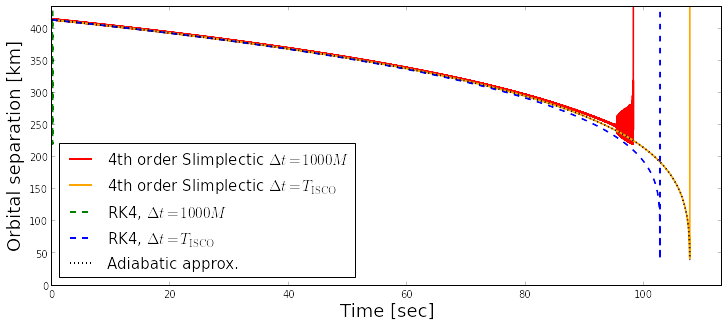

In [176]:
fig1 = plt.figure(figsize=(12,5), dpi=500)
#ax1 = fig1.add_subplot(211)
#ax2 = fig1.add_subplot(212)
#plt.subplots_adjust(hspace=0.05)
ax1 = fig1.add_subplot(111)

# Plot orbital separations
ax1.plot(t_1000, r_1000*sec_to_km, 'r-',  linewidth=2.0, rasterized = True, label='4th order Slimplectic $\Delta t=1000M$');
ax1.plot(t_Tisco, r_Tisco*sec_to_km, '-', color = 'orange', linewidth=2.0, rasterized = True,  label='4th order Slimplectic $\Delta t=T_{\\rm ISCO}$');
ax1.plot(t_1000, r_rk41000*sec_to_km, 'g--',  linewidth=2.0, rasterized = True, label='RK4, $\Delta t=1000M$');
ax1.plot(t_Tisco, r_rk4*sec_to_km, 'b--',  linewidth=2.0, rasterized = True, label='RK4, $\Delta t =T_{\\rm ISCO}$');

ax1.plot(t, r_adiab(t)*sec_to_km, 'k:',  linewidth=2.0, rasterized = True, label='Adiabatic approx.');
ax1.set_xlim(0, 1.05*tcoal);
#ax1.set_xticklabels([]);
ax1.set_ylim(0, 1.05*r0*sec_to_km);
ax1.set_ylabel('Orbital separation [km]', fontsize=18);
ax1.legend(loc='lower left', prop={'size':15});

# Plot absolute errors in orbital separations
#ax2.semilogy(t_1000, np.abs(r_1000-r_adiab(t_1000))/r_adiab(t_1000), 'r-',  linewidth=2.0, rasterized = True);
#ax2.semilogy(t_1000, np.abs(r_rk41000-r_adiab(t_1000))/r_adiab(t_1000), 'g--',   linewidth=2.0, rasterized = True);
#ax2.semilogy(t_Tisco, np.abs(r_Tisco-r_adiab(t_Tisco))/r_adiab(t_Tisco), '-', color = 'orange',  linewidth=2.0, rasterized = True);
#ax2.semilogy(t_Tisco, np.abs(r_rk4-r_adiab(t_Tisco))/r_adiab(t_Tisco), 'b--',  linewidth=2.0, rasterized = True);

#ax2.set_xlim(0, 1.05*tcoal);
#ax2.set_ylim(1e-10, 1e0);
#ax2.set_yticks([1e-8, 1e-4, 1, 1e4]);
ax1.set_xlabel('Time [sec]', fontsize = 18);


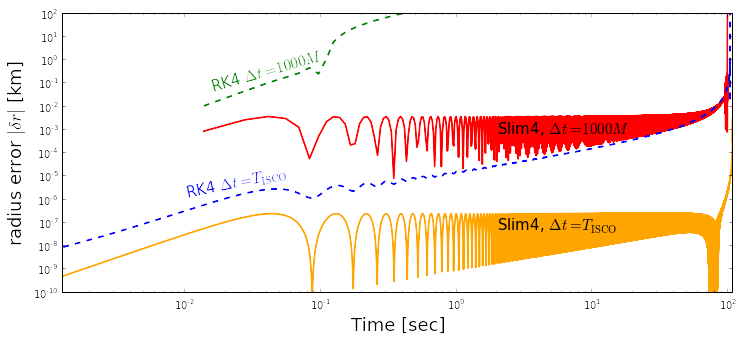

In [150]:
fig2 = plt.figure(figsize=(12,5), dpi=500)
ax2a = fig2.add_subplot(111)
# Plot orbital separations
# Plot absolute errors in orbital separations

ax2a.set_xscale('log')
ax2a.set_yscale('log')
ax2a.plot(t_1000, np.abs(r_1000-r_adiab(t_1000))/r_adiab(t_1000), 'r-', linewidth=2.0, rasterized = True);
ax2a.plot(t_Tisco, np.abs(r_Tisco-r_adiab(t_Tisco))/r_adiab(t_Tisco),  '-', color = 'orange', linewidth=2.0, rasterized = True);
ax2a.plot(t_Tisco, np.abs(r_rk4-r_adiab(t_Tisco))/r_adiab(t_Tisco), 'b--', linewidth=2.0, rasterized = True);
ax2a.plot(t_1000, np.abs(r_rk41000-r_adiab(t_1000))/r_adiab(t_1000), 'g--', linewidth=2.0, rasterized = True);

ax2a.text(2, 5e-8, r'Slim4, $\Delta t = T_{\rm ISCO}$', fontsize = 15, color = 'black')
ax2a.text(2, 7e-4, r'Slim4, $\Delta t = 1000M$', fontsize = 15, color = 'black')

ax2a.text(0.01, 1e-5, r'RK4 $\Delta t = T_{\rm ISCO}$', fontsize = 15, color = 'blue', rotation=12)
ax2a.text(0.015, 1e0, r'RK4 $\Delta t = 1000M$', fontsize = 15, color = 'green', rotation=16)


ax2a.set_xlim(0, tcoal);
ax2a.set_ylim(1e-10, 1e2)
#ax2.set_yticks([1e-8, 1e-4, 1, 1e4]);
ax2a.set_xlabel('Time [sec]', fontsize = 18);
ax2a.set_ylabel('radius error $|\delta r|$ [km]', fontsize = 18);


In [146]:
plot_path = './plots/'


In [151]:
fig2.savefig(plot_path + "PNInspiral_rError.pdf", transparent=True,bbox_inches='tight', dpi=500)

In [177]:
fig1.savefig(plot_path + "PNInspiral_r.pdf", transparent=True,bbox_inches='tight', dpi=500)

In [154]:
1000*m/T_isco

10.829122239356611

In [155]:
T_isco/m

92.34358777165423

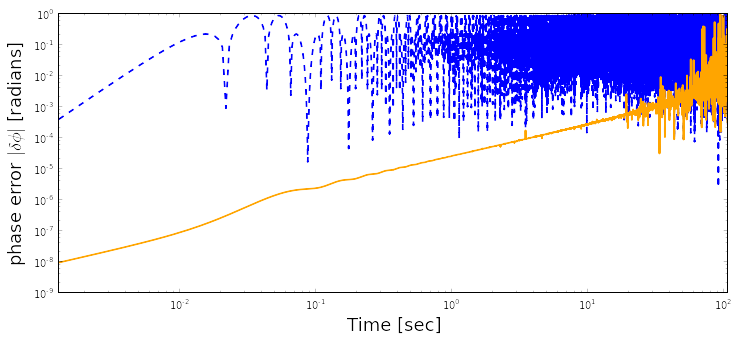

In [173]:
fig3 = plt.figure(figsize=(12,5), dpi=500)
ax3a = fig3.add_subplot(111)
# Plot orbital separations
# Plot absolute errors in orbital separations

ax3a.set_xscale('log')
ax3a.set_yscale('log')
ax3a.plot(t_Tisco, np.abs(qy_rk4/qx_rk4[0] - q6[1]/q6[0])*(q6[0]**2/(q6[0]**2 + q6[1]**2)), 'b--', linewidth=2.0, rasterized = True);
ax3a.plot(t_Tisco, np.abs(q_Tisco[1]/q_Tisco[0] - q6[1]/q6[0])*(q6[0]**2/(q6[0]**2 + q6[1]**2)), '-', color = 'orange', linewidth=2.0, rasterized = True);


ax3a.set_xlim(0, tcoal);
ax3a.set_ylim(1e-9, 1e0)
#ax3.set_yticks([1e-8, 1e-4, 1, 1e4]);
ax3a.set_xlabel('Time [sec]', fontsize = 18);
ax3a.set_ylabel('phase error $|\delta \phi|$ [radians]', fontsize = 18);


In [171]:
fig3.savefig(plot_path + "PNInspiral_PhaseError.pdf", transparent=True,bbox_inches='tight', dpi=500)

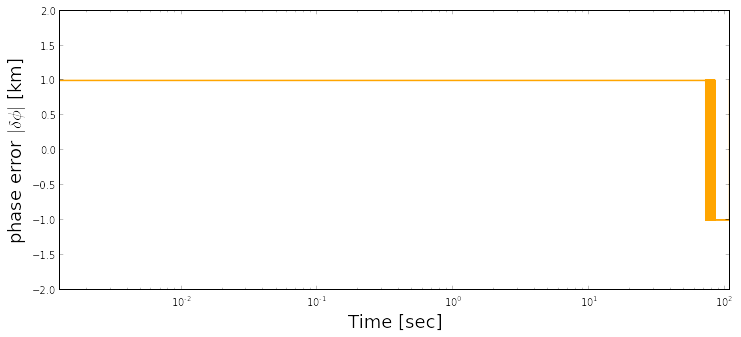

In [172]:
fig4 = plt.figure(figsize=(12,5), dpi=500)
ax4a = fig4.add_subplot(111)
# Plot orbital separations
# Plot absolute errors in orbital separations

ax4a.set_xscale('log')
ax4a.plot(t_Tisco, np.sign(r_Tisco-r_adiab(t_Tisco)),  '-', color = 'orange', linewidth=2.0, rasterized = True);


ax4a.set_xlim(0, tcoal);
ax4a.set_ylim(-2, 2)
#ax3.set_yticks([1e-8, 1e-4, 1, 1e4]);
ax4a.set_xlabel('Time [sec]', fontsize = 18);
ax4a.set_ylabel('phase error $|\delta \phi|$ [km]', fontsize = 18);